In [12]:
import os, struct
import numpy as np
import matplotlib.pyplot as plt
import pylab


def writeExcelData(x,excelfile,sheetname,startrow,startcol):
    from pandas import DataFrame, ExcelWriter
    from openpyxl import load_workbook
    df=DataFrame(x)
    book = load_workbook(excelfile)
    writer = ExcelWriter(excelfile, engine='openpyxl') 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name=sheetname,startrow=startrow-1, startcol=startcol-1, header=False, index=False)
    writer.save()
    writer.close()

In [4]:
def getSheetNames(excelfile):
    from pandas import ExcelFile
    return (ExcelFile(excelfile)).sheet_names

In [7]:
excelfile=r"Assignment_3_ Submission_Template.xlsx";
#excelfile
sheets=getSheetNames(excelfile);
sheets

[u'Results', u'Scatter Plot', u'Observations']

__Step 01:__<Br>
Import handwritten digit data from yann.lecun.com/exdb/mnist (four files). You only need the training data for this assignment. If you use Python, refer to the Python code suggested in Read_MNIST. htmlView in a new window to read and parse the data.

In [36]:
def load_mnist(dataset="training", digits=range(10), path='MNIST_Data'):
    
    """Adapted from github"""

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    with open(fname_lbl, 'rb') as flbl:
        magic_nr, size = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)
    
    images = np.zeros((N, rows, cols), dtype=np.uint8)
    labels = np.zeros((N, 1), dtype=np.int8)
    for i in range(len(ind)):
        images[i] = img[ind[i]]
        labels[i] = lbl[ind[i]]

    return images, labels

digits = [7, 9] #assigned digits

images, labels = load_mnist('training', digits=digits)

# converting from NX28X28 array into NX784 array
flatimages = list()
for i in images:
    flatimages.append(i.ravel())
X = np.asarray(flatimages)

In [ ]:
#PCA
mu=np.mean(X,axis=0)
Z=X-mu
C=np.cov(Z,rowvar=False)
[lam,V]=np.linalg.eigh(C);
lam=np.flipud(lam);V=np.flipud(V.T);

__What does _vector_ & _Transpose_ means?__ <BR>
In linear algebra, a column vector or column matrix is an m × 1 matrix, that is, a matrix consisting of a single column of m elements, ... Throughout, boldface is used for the row and column vectors. The transpose (indicated by T) of a row vector is a column vector.

![title](img/vector.jpg)

__Eigenvector__<Br>
https://www.youtube.com/watch?v=G4N8vJpf7hM

In [38]:
def PCA(X, numComp):
    #Takes a matrix and a number representing the number of principle components to be used in the approximation
    #Returns the approximation using numComp components and reconstructed matrix
    Z=X-mu
    P=np.dot(Z,V.T[:,0:numComp]); #Principal components
    R=np.dot(P,V[0:numComp,:]); #Reconstruction using numComp components
    Xrec=R+mu;
    return Z, P, R, Xrec

[Z, P, R, Xrec] = PCA(X, 2)

In [39]:
def compare(x, xrec):
    print("Actual image")
    plt.imshow(x.reshape(28, 28),interpolation='None', cmap=pylab.cm.gray)
    plt.show()

    print("Approximated image")
    plt.imshow(xrec.reshape(28, 28),interpolation='None', cmap=pylab.cm.gray)
    plt.show()

In [40]:
def separate(P, labels):
    col = P.shape[1]
    Pos = np.zeros(shape=(len(labels[labels==digits[1]]), col))
    Neg = np.zeros(shape=(len(labels[labels==digits[0]]), col))
    Pcount = 0; Ncount = 0;
    for i in range(len(labels)): 
        if labels[i] == digits[1]:
            Pos[Pcount] = P[i,:]
            Pcount += 1
        else:
            Neg[Ncount] = P[i,:]
            Ncount += 1
    return Pos, Neg

In [41]:
def Build2DBayesianClassifier(P, labels):
    [Pos, Neg] = separate(P, labels)
    mup = np.mean(Pos, axis=0)
    mun = np.mean(Neg, axis=0)
    covp = np.cov(Pos, rowvar=False)
    covn = np.cov(Neg, rowvar=False)
    Np = len(Pos)
    Nn = len(Neg)
    return mup, mun, covp, covn, Np, Nn 

In [42]:
def pdf(x, mu, sigma):
    d= np.alen(mu)
    dfact1 = (2*np.pi) ** d
    dfact2 = np.linalg.det(sigma)
    fact= 1/np.sqrt(dfact1*dfact2)
    xc=x-mu
    isigma=np.linalg.inv(sigma)
    return fact*np.exp(-0.5*np.einsum('ij,jk,ik->i', xc, isigma, xc))

In [43]:
def Apply2DBayesianClassifier(queries, mup, mun, covp, covn, Np, Nn):
    countP = Np * pdf(queries, mup, covp)
    countN = Nn * pdf(queries, mun, covn)
    resultlabel = np.full(np.alen(queries), "Indeterminate", dtype=object)
    indicesP = countP>countN
    indicesN = countN>countP
    resultlabel[indicesP] = digits[1]
    resultlabel[indicesN] = digits[0]
    resultprob = countP/(countP + countN)
    return resultlabel, resultprob
    
B = 25; #bin size

In [44]:
def Build2DHistogramClassifier(P, labels):
    pmin = np.min(P, axis=0)
    pmax = np.max(P, axis=0)
    Hp = np.zeros(shape=(B, B)); #creates empty bins
    Hn = np.zeros(shape=(B, B));
    for i in range(len(labels)): 
        j = int(round((B-1)*(P[i,0]-pmin[0])/(pmax[0]-pmin[0]))); 
        k = int(round((B-1)*(P[i,1]-pmin[1])/(pmax[1]-pmin[1])));
        if labels[i] == digits[1]:
            Hp[j, k] += 1
        else:
            Hn[j, k] += 1
    return Hp, Hn, pmin, pmax

In [45]:
def Apply2DHistogramClassifier(query, Hp, Hn, pmin, pmax):
    B = np.alen(Hp)
    RC = np.clip((np.round(((B-1) * (query-pmin)/(pmax-pmin)))).astype('int32'), 0, B-1)
    countP = Hp[RC[:,0], RC[:,1]]
    countN = Hn[RC[:,0], RC[:,1]]
    resultlabel = np.full(np.alen(RC), "Indeterminate", dtype=object)
    indicesP = countP > countN
    indicesN = countN > countP
    resultlabel[indicesP] = digits[1]
    resultlabel[indicesN] = digits[0]
    resultprob = countP/(countP + countN)
    return resultlabel, resultprob

In [46]:
def representatives(X, labels):
    [Pos, Neg] = separate(X, labels)
    ip = np.random.randint(0, len(Pos))
    jn = np.random.randint(0, len(Neg))
    return Pos[ip], Neg[jn]

Actual image


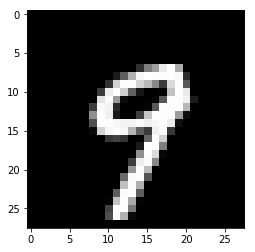

Approximated image


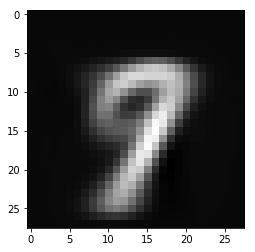

Actual image


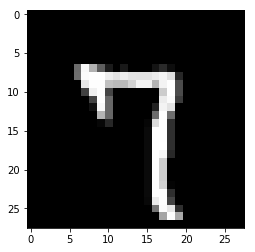

Approximated image


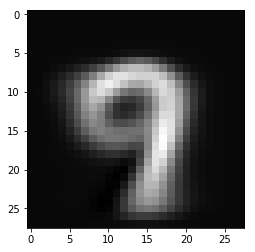

(array([7, 9], dtype=object), array([ 0.40740741,  0.59090909]))
(array([7, 9], dtype=object), array([ 0.49659702,  0.61199945]))
cnt8992
Len of labels :12214
 Histo accuracy :0.736204355657
My Accuracy
(0.7362043556574422, 0.7344031439331914)


/home/usherbond/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/usherbond/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


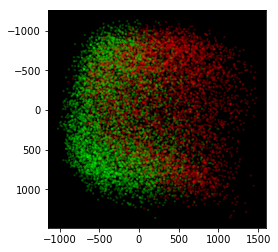

In [47]:
[mup, mun, covp, covn, Np, Nn] = Build2DBayesianClassifier(P, labels)
[Hp, Hn, pmin, pmax] = Build2DHistogramClassifier(P, labels)
[xp, xn] = representatives(X, labels)
[zp, pp, rp, xrecp] = PCA(xp, 2)
[zn, pn, rn, xrecn] = PCA(xn, 2)
compare(xp, xrecp)
compare(xn, xrecn)
[histPred, histProb] = Apply2DHistogramClassifier([pp,pn], Hp, Hn, pmin, pmax)
print(histPred, histProb)
[bayesPred, bayesProb] = Apply2DBayesianClassifier([pp, pn], mup, mun, covp, covn, Np, Nn)
print(bayesPred, bayesProb)

[histogramPredictions, histogramProbabilities] = Apply2DHistogramClassifier(P, Hp, Hn, pmin, pmax)
[bayesianPredictions, bayesianProbabilities] = Apply2DBayesianClassifier(P, mup, mun, covp, covn, Np, Nn)
cnt =0
for i in range(len(labels)):
    if histogramPredictions[i]==labels[i]:
        cnt+=1
print "cnt" + str(cnt)
print "Len of labels :" + str(len(labels))
a =float(cnt)/len(labels)

print " Histo accuracy :" + str(a)
        
        
    

histAccuracy = sum([1 for i in range(len(labels)) if histogramPredictions[i]==labels[i]])/float(len(labels))
bayesAccuracy = sum([1 for i in range(len(labels)) if bayesianPredictions[i]==labels[i]])/float(len(labels))
print "My Accuracy"
print(histAccuracy, bayesAccuracy)

cols=np.zeros((np.alen(labels),4));
for i in range(np.alen(labels)):
    if labels[i]==digits[0]:
        cols[i]=[1,0,0,0.25];
    else:
        cols[i]=[0,1,0,0.25];
randomorder=np.random.permutation(np.arange(np.alen(labels))); #Don't worry about this stuff. Just makes a pretty picture
 
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='black')
ax.scatter(P[randomorder,1],P[randomorder,0],s=5,linewidths=0,facecolors=cols[randomorder,:],marker="o");
ax.set_aspect('equal');
plt.gca().invert_yaxis();
plt.show()

In [48]:
#writes mu and v1, v2 into excel
writeExcelData((mu.T).reshape(1,784), excelfile, 'Results', 2,2)
writeExcelData(V[0:2,:], excelfile, 'Results', 3,2)

#writes Bayesian parameters
writeExcelData([Np, Nn], excelfile, 'Results', 6,2)
writeExcelData((mup.T).reshape(1,2), excelfile, 'Results', 9,2)
writeExcelData((mun.T).reshape(1,2), excelfile, 'Results', 10,2)
writeExcelData(covp, excelfile, 'Results', 12,2)
writeExcelData(covn, excelfile, 'Results', 14,2)

#writes Histogram parameters
writeExcelData(pmin, excelfile, 'Results', 17,2)
writeExcelData(pmax, excelfile, 'Results', 17,3)
writeExcelData(Hp, excelfile, 'Results', 20,2)
writeExcelData(Hn, excelfile, 'Results', 46,2)

#writes Positive Representative
writeExcelData((xp.T).reshape(1,784), excelfile, 'Results', 74,2)
writeExcelData((zp.T).reshape(1,784), excelfile, 'Results', 75,2)
writeExcelData((pp.T).reshape(1,2), excelfile, 'Results', 76,2)
writeExcelData((rp.T).reshape(1,784), excelfile, 'Results', 77,2)
writeExcelData((xrecp.T).reshape(1,784), excelfile, 'Results', 78,2)

#writes Negative Representative
writeExcelData((xn.T).reshape(1,784), excelfile, 'Results', 80,2)
writeExcelData((zn.T).reshape(1,784), excelfile, 'Results', 81,2)
writeExcelData((pn.T).reshape(1,2), excelfile, 'Results', 82,2)
writeExcelData((rn.T).reshape(1,784), excelfile, 'Results', 83,2)
writeExcelData((xrecn.T).reshape(1,784), excelfile, 'Results', 84,2)

#writes the results of classification
writeExcelData([histPred[0],bayesPred[0]], excelfile, 'Results', 89,2)
writeExcelData([histProb[0],bayesProb[0]], excelfile, 'Results', 89,3)
writeExcelData([histPred[1],bayesPred[1]], excelfile, 'Results', 93,2)
writeExcelData([1-histProb[1],1-bayesProb[1]], excelfile, 'Results', 93,3)
writeExcelData([histAccuracy,bayesAccuracy],excelfile,'Results',97,2)


#print("Done! Congratulations.")